In [11]:
from model import Model, postprocessing, accuracy, customLoss
import torch
import cv2
import torch.utils.data
import torch.nn.functional as F
import os
from skimage import io, transform, filters, feature
import numpy as np
from torchvision import transforms, utils
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [12]:
PATH_GT = 'test_label.json'
PATH_TEST = 'test_set/'

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        if(type(image) == list):
            return {'image': torch.Tensor(image), 'landmarks': torch.from_numpy(landmarks)}

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        #image = image.transpose((2, 0, 1))
        return {'image': transforms.functional.to_tensor(image), 'landmarks': torch.from_numpy(landmarks)}

In [14]:
def loadImage(imageObj,rootDir,outTransform):
    img_name = os.path.join(rootDir,  imageObj["raw_file"])
    image = transform.rescale(io.imread(img_name,as_gray=True),0.2, multichannel= False)
    image = feature.canny(image,2);
    #image = filters.gaussian(image,multichannel = True)
    laneWidths = imageObj["lanes"]
    laneHeights = imageObj["h_samples"]

    laneSamples = []
    for lane in laneWidths:
        for x in lane:
            if(x == -2):
                laneSamples.append(-2);
            else:
                laneSamples.append(x/5);

    landmarks = np.array([laneSamples])
    landmarks = landmarks.astype('int').reshape(1, -1)
    sample = {'image': image, 'landmarks': landmarks}

    if outTransform:
        sample = outTransform(sample)

    return sample

In [15]:
def show_landmarks(image, landmarks):
    plt.imshow(image)

    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=2, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


def showBestFit(image,lanes,landmarks):
    plt.imshow(image)

    plt.savefig('2.jpg')
    cDict = {1:'r',2:'b',3:'g',4:'y'}
    cl = 1
    for lane in lanes:
        if (cl == 4):
            plt.scatter(lane[:, 0], lane[:, 1], s=2, marker='.', c=cDict[cl])
        cl+=1
    count = 0
    for lane in lanes:
        if(count == 3):
            continue
            fit = np.polyfit(lane[:,0],lane[:,1], 1)
        else:
            fit = np.polyfit(lane[:,0],lane[:,1], 4)
        p = np.poly1d(fit)
        _ = plt.plot(lane[:,0], p(lane[:,0]), '.')
        count+=1
    plt.pause(0.05)  # pause a bit so that plots are updated
    plt.show()
#     plt.savefig('2.jpg')
#     plt.show()

<ipython-input-16-49a4cc0b59cb>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cleanLanes = np.array(tempLanes)


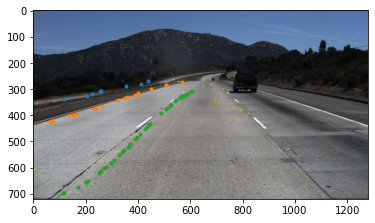

In [16]:
model = Model();
model.load_state_dict(torch.load('model2021-04-17-001003.482059epoch12accuracy45.pth'))

model.eval()
device = torch.device('cuda')
rootDir = 'test_set/'



gt = {"lanes": [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 600, 563, 525, 487, 450, 412, 374, 337, 299, 261, 224, 186, 148, 111, 73, 35, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 640, 627, 614, 600, 587, 574, 561, 547, 534, 521, 508, 494, 481, 468, 454, 441, 428, 415, 401, 388, 375, 362, 348, 335, 322, 309, 295, 282, 269, 256, 242, 229, 216, 202, 189, 176, 163, 149, 136, 123, 110, 96, 83, 70, 57], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 695, 705, 716, 726, 737, 747, 758, 768, 779, 789, 800, 810, 821, 831, 842, 852, 863, 873, 884, 894, 905, 915, 926, 936, 947, 957, 968, 978, 989, 999, 1010, 1020, 1031, 1041, 1052, 1062, 1073, 1083, 1094, 1104, 1115, 1125, 1136, 1146, 1157], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 734, 766, 799, 831, 863, 895, 927, 959, 991, 1023, 1055, 1087, 1119, 1151, 1183, 1215, 1247, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]], "h_samples": [160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710], "raw_file": "clips/0530/1492627032622200926_0/20.jpg"}
testData = loadImage(gt,rootDir,ToTensor())
image = torch.cat(20*[testData['image']])
landmark = testData['landmarks'].flatten()
image, landmark = image.to(device), landmark.to(device)	
model = model.to(device)
output = postprocessing(model(image.float()))

output = output *5
heightTensor = torch.tensor(gt['h_samples'])
heightTensor = torch.cat(4*[heightTensor])

output = output.to(torch.device('cpu'))
tempOutput = output.view(4,56);
tempOutput = tempOutput.detach().cpu().numpy()

output = torch.stack((output,heightTensor),1)
outLanes = output.view(4,56,2)
output = output.detach().cpu().numpy()
outLanes = outLanes.detach().cpu().numpy()

# pred_lanes = outLanes[:, :, 0]

tempLanes = []
for lane in outLanes:
	tempLanes.append(lane[lane[:,0] > 0])

cleanLanes = np.array(tempLanes)
# print(cleanLanes);
	




#show_landmarks(io.imread(rootDir+imageObj['raw_file']),output)


# show_landmarks(io.imread(rootDir+gt['raw_file']),output)
showBestFit(io.imread(rootDir+gt['raw_file']),cleanLanes,output)


In [23]:
lr = LinearRegression()
pixel_thresh = 20
pt_thresh = 0.85

def get_angle(xs, y_samples):
    xs, ys = xs[xs >= 0], y_samples[xs >= 0]
    if len(xs) > 1:
        lr.fit(ys[:, None], xs)
        k = lr.coef_[0]
        theta = np.arctan(k)
    else:
        theta = 0
    return theta

def line_accuracy(pred, gt, thresh):
    pred = np.array([p if p >= 0 else -100 for p in pred])
    gt = np.array([g if g >= 0 else -100 for g in gt])
    return np.sum(np.where(np.abs(pred - gt) < thresh, 1., 0.)) / len(gt)

def bench(pred, gt, y_samples):
    if any(len(p) != len(y_samples) for p in pred):
        raise Exception('Format of lanes error.')
    if len(gt) + 2 < len(pred):
        return 0., 0., 1.
    angles = [get_angle(np.array(x_gts), np.array(y_samples)) for x_gts in gt]
    threshs = [pixel_thresh / np.cos(angle) for angle in angles]
    line_accs = []
    fp, fn = 0., 0.
    matched = 0.
    for x_gts, thresh in zip(gt, threshs):
        accs = [line_accuracy(np.array(x_preds), np.array(x_gts), thresh) for x_preds in pred]
        max_acc = np.max(accs) if len(accs) > 0 else 0.
        if max_acc < pt_thresh:
            fn += 1
        else:
            matched += 1
        line_accs.append(max_acc)
    fp = len(pred) - matched
    if len(gt) > 4 and fn > 0:
        fn -= 1
    s = sum(line_accs)
    if len(gt) > 4:
        s -= min(line_accs)
    return s / max(min(4.0, len(gt)), 1.), fp / len(pred) if len(pred) > 0 else 0., fn / max(min(len(gt), 4.) , 1.)

In [16]:
def test_model():
    model = Model();
    model.load_state_dict(torch.load('model2021-04-17-001003.482059epoch12accuracy45.pth'))

    model.eval()
    device = torch.device('cuda')
    rootDir = 'test_set/'

    gts = [json.loads(line) for line in open(PATH_GT)]
    accuracy, fp, fn = 0., 0., 0.
    num = len(gts)


    for gt in gts:
        testData = loadImage(gt,rootDir,ToTensor())
        image = torch.cat([testData['image']])
        landmark = testData['landmarks'].flatten()
        image, landmark = image.to(device), landmark.to(device)	
        model = model.to(device)
        output = postprocessing(model(image.float()))

        output = output *5
        heightTensor = torch.tensor(gt['h_samples'])
        heightTensor = torch.cat(4*[heightTensor])

        output = output.to(torch.device('cpu'))
        tempOutput = output.view(4,56);
        tempOutput = tempOutput.detach().cpu().numpy()

        output = torch.stack((output,heightTensor),1)
        outLanes = output.view(4,56,2)
        output = output.detach().cpu().numpy()
        outLanes = outLanes.detach().cpu().numpy()

        pred_lanes = outLanes[:, :, 0].tolist()
        

        gt_lanes = gt['lanes']
        y_samples = gt['h_samples']
        img_path = f'{PATH_TEST}{gt["raw_file"]}'
        print(img_path)

        a, p, n = bench(pred_lanes, gt_lanes, y_samples)
        accuracy += a
        fp += p
        fn += n
    return accuracy / num, fp / num, fn / num

In [17]:
accuracy, fp, fn = test_model()
print(f'Accuracy: {accuracy}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')

test_set/clips/0530/1492626760788443246_0/20.jpg
test_set/clips/0530/1492627171538356342_0/20.jpg
test_set/clips/0530/1492627288467128445_0/20.jpg
test_set/clips/0530/1492626397007603377_0/20.jpg
test_set/clips/0530/1492626617873533069_0/20.jpg
test_set/clips/0530/1492626286076989589_0/20.jpg
test_set/clips/0530/1492627068602933406_0/20.jpg
test_set/clips/0530/1492626838739876007_0/20.jpg
test_set/clips/0530/1492626861725776049_0/20.jpg
test_set/clips/0530/1492626126171818168_0/20.jpg
test_set/clips/0530/1492626153155598528_0/20.jpg
test_set/clips/0530/1492626257094533319_0/20.jpg
test_set/clips/0530/1492626352035311824_0/20.jpg
test_set/clips/0530/1492626171146236124_0/20.jpg
test_set/clips/0530/1492626717813442341_0/20.jpg
test_set/clips/0530/1492626624869329136_0/20.jpg
test_set/clips/0530/1492626252095353084_0/20.jpg
test_set/clips/0530/1492627287468650122_0/20.jpg
test_set/clips/0530/1492626710817184556_0/20.jpg
test_set/clips/0530/1492626520934288174_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492626729805702922_0/20.jpg
test_set/clips/0530/1492626365026938643_0/20.jpg
test_set/clips/0530/1492626463967080222_0/20.jpg
test_set/clips/0530/1492627059605858352_0/20.jpg
test_set/clips/0530/1492626581895428615_0/20.jpg
test_set/clips/0530/1492626542919708477_0/20.jpg
test_set/clips/0530/1492626975657150279_0/20.jpg
test_set/clips/0530/1492627205517371213_0/20.jpg
test_set/clips/0530/1492626447976734549_0/20.jpg
test_set/clips/0530/1492627071599036251_0/20.jpg
test_set/clips/0530/1492626918691301219_0/20.jpg
test_set/clips/0530/1492626896704559322_0/20.jpg
test_set/clips/0530/1492626660847529842_0/20.jpg
test_set/clips/0530/1492626333048395643_0/20.jpg
test_set/clips/0530/1492626974659207042_0/20.jpg
test_set/clips/0530/1492626510939139979_0/20.jpg
test_set/clips/0530/1492626988650418067_0/20.jpg
test_set/clips/0530/1492627163542737719_0/20.jpg
test_set/clips/0530/1492626756789374886_0/20.jpg
test_set/clips/0530/1492627315450775468_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492627690357370915_0/20.jpg
test_set/clips/0530/1492628379939575351_0/20.jpg
test_set/clips/0530/1492628058134253237_0/20.jpg
test_set/clips/0530/1492627906226210382_0/20.jpg
test_set/clips/0530/1492627905229321814_0/20.jpg
test_set/clips/0530/1492627509466736747_0/20.jpg
test_set/clips/0530/1492627370551744103_0/20.jpg
test_set/clips/0530/1492627765314283120_0/20.jpg
test_set/clips/0530/1492627772307351163_0/20.jpg
test_set/clips/0530/1492627487481443970_0/20.jpg
test_set/clips/0530/1492628299987988107_0/20.jpg
test_set/clips/0530/1492627448503569456_0/20.jpg
test_set/clips/0530/1492628168067716766_0/20.jpg
test_set/clips/0530/1492627682361773741_0/20.jpg
test_set/clips/0530/1492627834271872693_0/20.jpg
test_set/clips/0530/1492628146081048262_0/20.jpg
test_set/clips/0530/1492628089115565431_0/20.jpg
test_set/clips/0530/1492628261011859162_0/20.jpg
test_set/clips/0530/1492627556438095568_0/20.jpg
test_set/clips/0530/1492628151078072498_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492630568183109828_0/20.jpg
test_set/clips/0530/1492630348315926731_0/20.jpg
test_set/clips/0530/1492630077479545043_0/20.jpg
test_set/clips/0530/1492630013518282969_0/20.jpg
test_set/clips/0530/1492629977540008159_0/20.jpg
test_set/clips/0530/1492629808642156775_0/20.jpg
test_set/clips/0530/1492630633143870969_0/20.jpg
test_set/clips/0530/1492630140443199734_0/20.jpg
test_set/clips/0530/1492630502225894528_0/20.jpg
test_set/clips/0530/1492630525209094421_0/20.jpg
test_set/clips/0530/1492630120453660956_0/20.jpg
test_set/clips/0530/1492630431265837350_0/20.jpg
test_set/clips/0530/1492630073482137906_0/20.jpg
test_set/clips/0530/1492629839624266041_0/20.jpg
test_set/clips/0530/1492630108460880317_0/20.jpg
test_set/clips/0530/1492630247378682190_0/20.jpg
test_set/clips/0530/1492630774058754391_0/20.jpg
test_set/clips/0530/1492629978539389288_0/20.jpg
test_set/clips/0530/1492630304342595952_0/20.jpg
test_set/clips/0530/1492630679116103145_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492630063490885633_0/20.jpg
test_set/clips/0530/1492630405281533960_0/20.jpg
test_set/clips/0530/1492630818032178013_0/20.jpg
test_set/clips/0530/1492630349315319837_0/20.jpg
test_set/clips/0530/1492629823632972549_0/20.jpg
test_set/clips/0530/1492630475239245785_0/20.jpg
test_set/clips/0530/1492629775662096437_0/20.jpg
test_set/clips/0530/1492630572180684863_0/20.jpg
test_set/clips/0530/1492630386293027988_0/20.jpg
test_set/clips/0530/1492630450254356565_0/20.jpg
test_set/clips/0530/1492630306341517405_0/20.jpg
test_set/clips/0530/1492631893317644412_0/20.jpg
test_set/clips/0530/1492631608489007266_0/20.jpg
test_set/clips/0530/1492631691439206574_0/20.jpg
test_set/clips/0530/1492631560517851326_0/20.jpg
test_set/clips/0530/1492631501553952982_0/20.jpg
test_set/clips/0530/1492631569512810732_0/20.jpg
test_set/clips/0530/1492631839350132179_0/20.jpg
test_set/clips/0530/1492631547531297041_0/20.jpg
test_set/clips/0530/1492631495557021988_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492635607256534909_0/20.jpg
test_set/clips/0530/1492634949652914954_0/20.jpg
test_set/clips/0530/1492635165521998613_0/20.jpg
test_set/clips/0530/1492634802740491042_0/20.jpg
test_set/clips/0530/1492635571280902972_0/20.jpg
test_set/clips/0530/1492634720789508931_0/20.jpg
test_set/clips/0530/1492634647833846606_0/20.jpg
test_set/clips/0530/1492635244476328792_0/20.jpg
test_set/clips/0530/1492634853709505378_0/20.jpg
test_set/clips/0530/1492635044594834286_0/20.jpg
test_set/clips/0530/1492635003621479316_0/20.jpg
test_set/clips/0530/1492635018610365318_0/20.jpg
test_set/clips/0530/1492635142535853975_0/20.jpg
test_set/clips/0530/1492635405382308763_0/20.jpg
test_set/clips/0530/1492634637839471526_0/20.jpg
test_set/clips/0530/1492635376395981744_0/20.jpg
test_set/clips/0530/1492635567280597946_0/20.jpg
test_set/clips/0530/1492635293445768146_0/20.jpg
test_set/clips/0530/1492634912676502495_0/20.jpg
test_set/clips/0530/1492635101562536937_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492638113215039138_0/20.jpg
test_set/clips/0530/1492638668879668949_0/20.jpg
test_set/clips/0530/1492638302101399279_0/20.jpg
test_set/clips/0530/1492637762426652515_0/20.jpg
test_set/clips/0530/1492638743834232693_0/20.jpg
test_set/clips/0530/1492637938320574349_0/20.jpg
test_set/clips/0530/1492637844377274277_0/20.jpg
test_set/clips/0530/1492638499981502389_0/20.jpg
test_set/clips/0530/1492638606918631841_0/20.jpg
test_set/clips/0530/1492638480993150954_0/20.jpg
test_set/clips/0530/1492638911735654403_0/20.jpg
test_set/clips/0530/1492638941714753572_0/20.jpg
test_set/clips/0530/1492638636898887729_0/20.jpg
test_set/clips/0530/1492638408037050500_0/20.jpg
test_set/clips/0530/1492638752831441083_0/20.jpg
test_set/clips/0530/1492638402040596736_0/20.jpg
test_set/clips/0530/1492637820394498338_0/20.jpg
test_set/clips/0530/1492638231143852352_0/20.jpg
test_set/clips/0530/1492638327085918575_0/20.jpg
test_set/clips/0530/1492637738441533852_0/20.jpg
test_set/clips/0530/

test_set/clips/0530/1492720257762556176_0/20.jpg
test_set/clips/0530/1492720183607312769_0/20.jpg
test_set/clips/0530/1492720386684733881_0/20.jpg
test_set/clips/0530/1492720465004225068_0/20.jpg
test_set/clips/0530/1492720209758175848_0/20.jpg
test_set/clips/0530/1492720840345996040_0/20.jpg
test_set/clips/0530/1492720217220371435_0/20.jpg
test_set/clips/0530/1492721432886472057_0/20.jpg
test_set/clips/0530/1492720417632656484_0/20.jpg
test_set/clips/0530/1492721433552704788_0/20.jpg
test_set/clips/0530/1492720268723156106_0/20.jpg
test_set/clips/0530/1492720299805545699_0/20.jpg
test_set/clips/0530/1492720227080989954_0/20.jpg
test_set/clips/0530/1492720255030877453_0/20.jpg
test_set/clips/0530/1492720211957206385_0/20.jpg
test_set/clips/0530/1492720220185730033_0/20.jpg
test_set/clips/0530/1492720201463893488_0/20.jpg
test_set/clips/0530/1492720581067740730_0/20.jpg
test_set/clips/0530/1492720257131019848_0/20.jpg
test_set/clips/0530/1492720236876811973_0/20.jpg
test_set/clips/0530/

test_set/clips/0531/1492628741021852199/20.jpg
test_set/clips/0531/1492628742154362911/20.jpg
test_set/clips/0531/1492628744719501991/20.jpg
test_set/clips/0531/1492628745752079739/20.jpg
test_set/clips/0531/1492628748683581912/20.jpg
test_set/clips/0531/1492628750151281927/20.jpg
test_set/clips/0531/1492628752214081481/20.jpg
test_set/clips/0531/1492628753214604895/20.jpg
test_set/clips/0531/1492628755813584156/20.jpg
test_set/clips/0531/1492628756811316586/20.jpg
test_set/clips/0531/1492628758843461643/20.jpg
test_set/clips/0531/1492628759843106892/20.jpg
test_set/clips/0531/1492628763407344447/20.jpg
test_set/clips/0531/1492628765839172717/20.jpg
test_set/clips/0531/1492628784394669656/20.jpg
test_set/clips/0531/1492628785560580255/20.jpg
test_set/clips/0531/1492628787992527189/20.jpg
test_set/clips/0531/1492628788992066936/20.jpg
test_set/clips/0531/1492628791892679406/20.jpg
test_set/clips/0531/1492628792926986263/20.jpg
test_set/clips/0531/1492628810148112071/20.jpg
test_set/clip

test_set/clips/0531/1492635419637621960/20.jpg
test_set/clips/0531/1492635421901926440/20.jpg
test_set/clips/0531/1492635425133375781/20.jpg
test_set/clips/0531/1492635492425508308/20.jpg
test_set/clips/0531/1492635523873705532/20.jpg
test_set/clips/0531/1492635546926112236/20.jpg
test_set/clips/0531/1492635549292553036/20.jpg
test_set/clips/0531/1492635555287799062/20.jpg
test_set/clips/0531/1492635556553703521/20.jpg
test_set/clips/0531/1492635569079615104/20.jpg
test_set/clips/0531/1492635570378837124/20.jpg
test_set/clips/0531/1492635576477496714/20.jpg
test_set/clips/0531/1492635607056705529/20.jpg
test_set/clips/0531/1492635610121844877/20.jpg
test_set/clips/0531/1492635711627226753/20.jpg
test_set/clips/0531/1492635803872100797/20.jpg
test_set/clips/0531/1492635835219702058/20.jpg
test_set/clips/0531/1492635838017983538/20.jpg
test_set/clips/0531/1492635942257653533/20.jpg
test_set/clips/0531/1492635948385025702/20.jpg
test_set/clips/0531/1492635950017419056/20.jpg
test_set/clip

test_set/clips/0531/1492638173678537940/20.jpg
test_set/clips/0531/1492638178377953940/20.jpg
test_set/clips/0531/1492638192100661712/20.jpg
test_set/clips/0531/1492638208126576446/20.jpg
test_set/clips/0531/1492638210422907495/20.jpg
test_set/clips/0531/1492638226013551048/20.jpg
test_set/clips/0531/1492638228146895567/20.jpg
test_set/clips/0531/1492638229178283132/20.jpg
test_set/clips/0531/1492638245337349327/20.jpg
test_set/clips/0531/1492638293772682589/20.jpg
test_set/clips/0531/1492638298503091596/20.jpg
test_set/clips/0531/1492638309496541848/20.jpg
test_set/clips/0531/1492638320589814777/20.jpg
test_set/clips/0531/1492638323554616115/20.jpg
test_set/clips/0531/1492638347775736574/20.jpg
test_set/clips/0531/1492638384719572779/20.jpg
test_set/clips/0531/1492638399175704698/20.jpg
test_set/clips/0531/1492638412800797419/20.jpg
test_set/clips/0531/1492638416533956519/20.jpg
test_set/clips/0531/1492638420496100516/20.jpg
test_set/clips/0531/1492638425228746225/20.jpg
test_set/clip

test_set/clips/0531/1492728028963277308/20.jpg
test_set/clips/0531/1492728214585375695/20.jpg
test_set/clips/0531/1492728244434125969/20.jpg
test_set/clips/0531/1492729038957583267/20.jpg
test_set/clips/0531/1492729039990202941/20.jpg
test_set/clips/0531/1492729085263099246/20.jpg
test_set/clips/0531/1492729086495576633/20.jpg
test_set/clips/0531/1492729116446922625/20.jpg
test_set/clips/0531/1492729117444122029/20.jpg
test_set/clips/0531/1492729127271025639/20.jpg
test_set/clips/0531/1492729132567855077/20.jpg
test_set/clips/0531/1492729139164775216/20.jpg
test_set/clips/0531/1492729140532526751/20.jpg
test_set/clips/0531/1492729146693252465/20.jpg
test_set/clips/0531/1492729147860550153/20.jpg
test_set/clips/0531/1492729150257451101/20.jpg
test_set/clips/0531/1492729157219668245/20.jpg
test_set/clips/0531/1492729170445039996/20.jpg
test_set/clips/0531/1492729172310873410/20.jpg
test_set/clips/0531/1492729195663313257/20.jpg
test_set/clips/0531/1492729207323141144/20.jpg
test_set/clip

test_set/clips/0601/1494453783479233565/20.jpg
test_set/clips/0601/1494453785478375673/20.jpg
test_set/clips/0601/1494453789476703453/20.jpg
test_set/clips/0601/1494453791477237256/20.jpg
test_set/clips/0601/1494453795474053315/20.jpg
test_set/clips/0601/1494453797473148355/20.jpg
test_set/clips/0601/1494453801471404934/20.jpg
test_set/clips/0601/1494453803471804263/20.jpg
test_set/clips/0601/1494453807468785234/20.jpg
test_set/clips/0601/1494453809467806176/20.jpg
test_set/clips/0601/1494453813470189243/20.jpg
test_set/clips/0601/1494453815467979971/20.jpg
test_set/clips/0601/1494453819463542735/20.jpg
test_set/clips/0601/1494453821462558376/20.jpg
test_set/clips/0601/1494453825461057694/20.jpg
test_set/clips/0601/1494453827460563310/20.jpg
test_set/clips/0601/1494453831458221916/20.jpg
test_set/clips/0601/1494453833457381785/20.jpg
test_set/clips/0601/1494453837458138028/20.jpg
test_set/clips/0601/1494453839454685269/20.jpg
test_set/clips/0601/1494453843452888293/20.jpg
test_set/clip

test_set/clips/0601/1495058899483245045/20.jpg
test_set/clips/0601/1495058903479584639/20.jpg
test_set/clips/0601/1495058905478033563/20.jpg
test_set/clips/0601/1495058909478434329/20.jpg
test_set/clips/0601/1495058911476464039/20.jpg
test_set/clips/0601/1495058915473553999/20.jpg
test_set/clips/0601/1495058917472643059/20.jpg
test_set/clips/0601/1495058921472223810/20.jpg
test_set/clips/0601/1495058923470000390/20.jpg
test_set/clips/0601/1495058927468205806/20.jpg
test_set/clips/0601/1495058929467422691/20.jpg
test_set/clips/0601/1495058933467743065/20.jpg
test_set/clips/0601/1495058935467362568/20.jpg
test_set/clips/0601/1495058939462932080/20.jpg
test_set/clips/0601/1495058941462104067/20.jpg
test_set/clips/0601/1495058945462237078/20.jpg
test_set/clips/0601/1495058947460270186/20.jpg
test_set/clips/0601/1495485005644829619/20.jpg
test_set/clips/0601/1495485007642298695/20.jpg
test_set/clips/0601/1495485011640575692/20.jpg
test_set/clips/0601/1495485013639706976/20.jpg
test_set/clip

test_set/clips/0601/1495492702579432167/20.jpg
test_set/clips/0601/1495492706575263699/20.jpg
test_set/clips/0601/1495492708574325026/20.jpg
test_set/clips/0601/1495492712572976070/20.jpg
test_set/clips/0601/1495492714571919589/20.jpg
test_set/clips/0601/1495492718570003186/20.jpg
test_set/clips/0601/1495492720570470111/20.jpg
test_set/clips/0601/1495492724569960208/20.jpg
test_set/clips/0601/1495492726566736573/20.jpg
test_set/clips/0601/1495492730564960952/20.jpg
test_set/clips/0601/1495492732564099641/20.jpg
test_set/clips/0601/1495492736564669027/20.jpg
test_set/clips/0601/1495492738561463722/20.jpg
test_set/clips/0601/1495492742562547671/20.jpg
test_set/clips/0601/1495492744561641614/20.jpg
test_set/clips/0601/1495492748563863341/20.jpg
test_set/clips/0601/1495492750556508768/20.jpg
test_set/clips/0601/1495492754556334960/20.jpg
test_set/clips/0601/1495492756556281736/20.jpg
test_set/clips/0601/1495492760554751621/20.jpg
test_set/clips/0601/1495492762551232540/20.jpg
test_set/clip

test_set/clips/0601/1494452917858649513/20.jpg
test_set/clips/0601/1494452921856946234/20.jpg
test_set/clips/0601/1494452923856000328/20.jpg
test_set/clips/0601/1494452927854312215/20.jpg
test_set/clips/0601/1494452929853344267/20.jpg
test_set/clips/0601/1494452933852394891/20.jpg
test_set/clips/0601/1494452935851509057/20.jpg
test_set/clips/0601/1494452939849078051/20.jpg
test_set/clips/0601/1494452941848207479/20.jpg
test_set/clips/0601/1494452945846416960/20.jpg
test_set/clips/0601/1494452947845566905/20.jpg
test_set/clips/0601/1494452951843767836/20.jpg
test_set/clips/0601/1494452953842851359/20.jpg
test_set/clips/0601/1494452957841111858/20.jpg
test_set/clips/0601/1494452959840189782/20.jpg
test_set/clips/0601/1494452963838542317/20.jpg
test_set/clips/0601/1494452965837655099/20.jpg
test_set/clips/0601/1494452969835798706/20.jpg
test_set/clips/0601/1494452971837724459/20.jpg
test_set/clips/0601/1494452975833353003/20.jpg
test_set/clips/0601/1494452977832376378/20.jpg
test_set/clip

test_set/clips/0601/1494453443628200744/20.jpg
test_set/clips/0601/1494453445627355185/20.jpg
test_set/clips/0601/1494453449625970265/20.jpg
test_set/clips/0601/1494453451625399256/20.jpg
test_set/clips/0601/1494453455622947381/20.jpg
test_set/clips/0601/1494453457622073759/20.jpg
test_set/clips/0601/1494453461620351396/20.jpg
test_set/clips/0601/1494453463620415597/20.jpg
test_set/clips/0601/1494453467617697485/20.jpg
test_set/clips/0601/1494453469616844083/20.jpg
test_set/clips/0601/1494453473615115896/20.jpg
test_set/clips/0601/1494453475619239031/20.jpg
test_set/clips/0601/1494453479612416875/20.jpg
test_set/clips/0601/1494453481611650216/20.jpg
test_set/clips/0601/1494453485609794205/20.jpg
test_set/clips/0601/1494453487610284129/20.jpg
test_set/clips/0601/1494453491607297875/20.jpg
test_set/clips/0601/1494453493606259181/20.jpg
test_set/clips/0601/1494453659533594147/20.jpg
test_set/clips/0601/1495058511650900131/20.jpg
test_set/clips/0601/1494452577507766671/20.jpg
Accuracy: 0.5